## Chapter 2 of the Hands-on Machine Learning book

### First Download the data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.exists():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Find what categories exits in the ocean_proximity column:

In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Summary of the numerical attributes:

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
import matplotlib.pyplot as plt

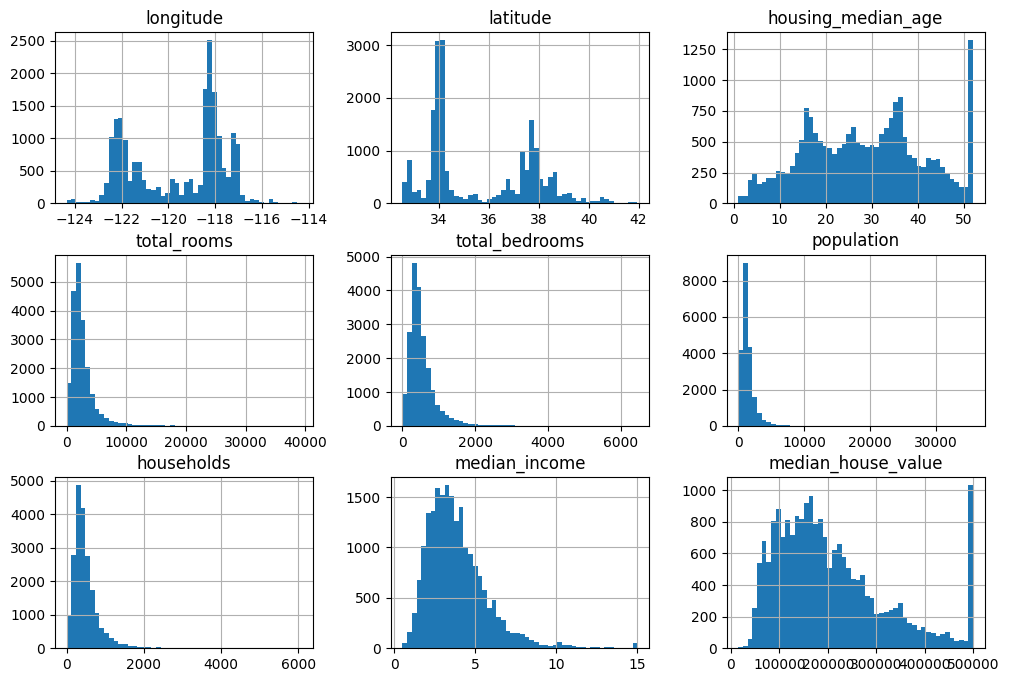

In [8]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

### Now, create a test set. Split the data into test and train sets

In [9]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [11]:
len(train_set)

16512

In [12]:
len(test_set)

4128

This will not always ensure the same data-split. Therefore it can be done with IDs.

In [13]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int32(identifier)) < test_ratio*2**32

def split_data_with_id_hash(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Suppose a dataframe has a column 'index' then it will be used like this:
* train_set, test_set = split_data_with_id_hash(df, 0.2, 'index')


However, this dataset does not have an 'index' column and therefore you can create a simple one as follows:


In [14]:
housing_with_id = housing.reset_index() #Adds the index column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

To use row index a a unique identifier you have to make sure new data is appended to the end of the dataset and that no row ever gets deleted. Alternatively, make a unique identifier using a particular value, e.g. longitude latitude which would always be unique:

In [15]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Sci-kit learn built in functions:

Setting random_state=42 in the train_test_split function is a way to make your results reproducible and consistent.

Here's what’s happening:

* random_state is a parameter that controls how the random number generator splits your data into train and test sets.

* Every time you run train_test_split without a set random_state, it will split the data differently (because of random shuffling).

* If you set random_state to a specific (any) integer (like 42), it will use the same internal sequence of random numbers every time.

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Fixing the Strata (Stratification)

Median salaries are mostly in the category of 1.5 - 6 however there is a lot that stretch far beyond that. Each strata should have sufficient number of instances otherwise you risk that the estimate of a statum's importance may be biased. 

In short: Don't have too many strata and have sufficient instances for each stratum.

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], 
                               labels= [1,2,3,4,5])

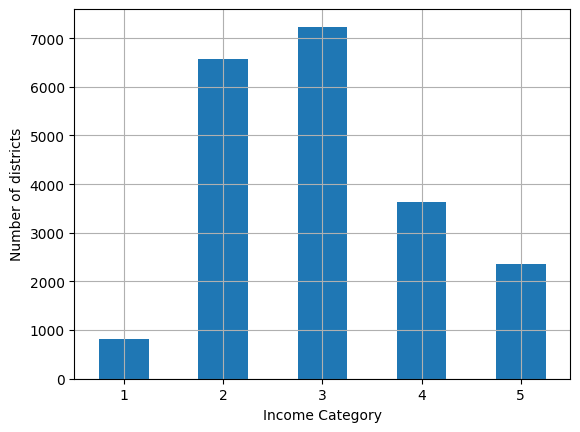

In [18]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

Stratified sampling keeps your sample distribution aligned with the original dataset, reducing bias and producing better model performance and evaluation when dealing with heterogeneous or imbalanced data

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

In [20]:
# Using the first split
strat_train_set, strat_test_set = strat_splits[0]

In [21]:
# Simpler way to get it using the *stratify* argument
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"],
                                                   random_state=42)

Practical Rule
Stratify by a feature like median_income when:
* The feature has a strong influence on your outcome (target variable),
* Its distribution is skewed or contains important rare groups,
* You want to ensure all subgroups (e.g., all income levels) are proportionally present in both training and test sets.

In [22]:
# Check if it works as expected
print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))


income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


In [23]:
# Wont use the 'income cat' column again, so drop it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Explore and visualize data to gain insights

We are going to experiment with various transformations of the full training set, therefore we should make a copy we can revert to afterwards:

In [24]:
housing = strat_train_set.copy()

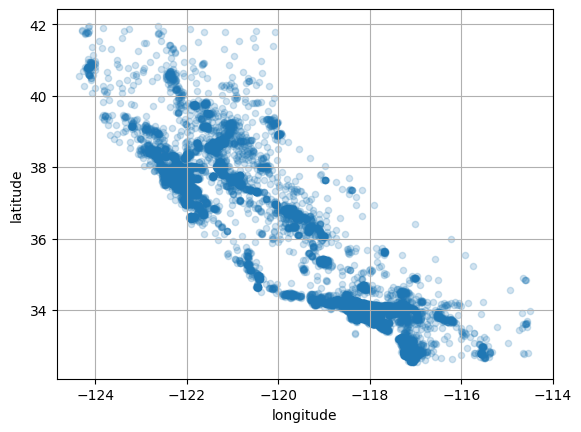

In [25]:
housing.plot(kind="scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2)
# Setting alpha to 0.2 makes it easier to visualize the places where there is a high density of data points
plt.show()

We can make it even better by utilizing the radius of each circle to present the **district population** and the color to represent the **prices**. Use the pre-defined color map called *jet*.

<Axes: xlabel='longitude', ylabel='latitude'>

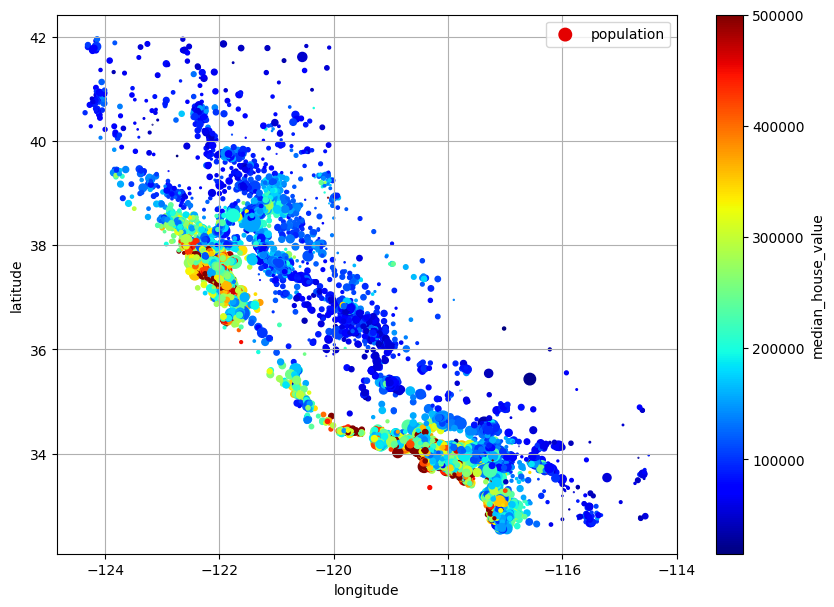

In [26]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,
             s=housing["population"]/100,label="population",c="median_house_value",
             cmap="jet",colorbar=True,legend=True,sharex=False,figsize=(10,7))

### Looking for correlations

Calculate the **standard correlation coefficient** or *Pearson's r*

In [27]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)
#corr_matrix["population"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Correlations coefficients range from -1 to 1. Closer to one represents a strong positive correlation.  

What we can see from the correlations:
* Positive correlation between median income and median house value, therefore as income goes up so does the house value
* Small negative correlation between latitude and the median house value, therefore house prices tend to decrease slightly as you go north

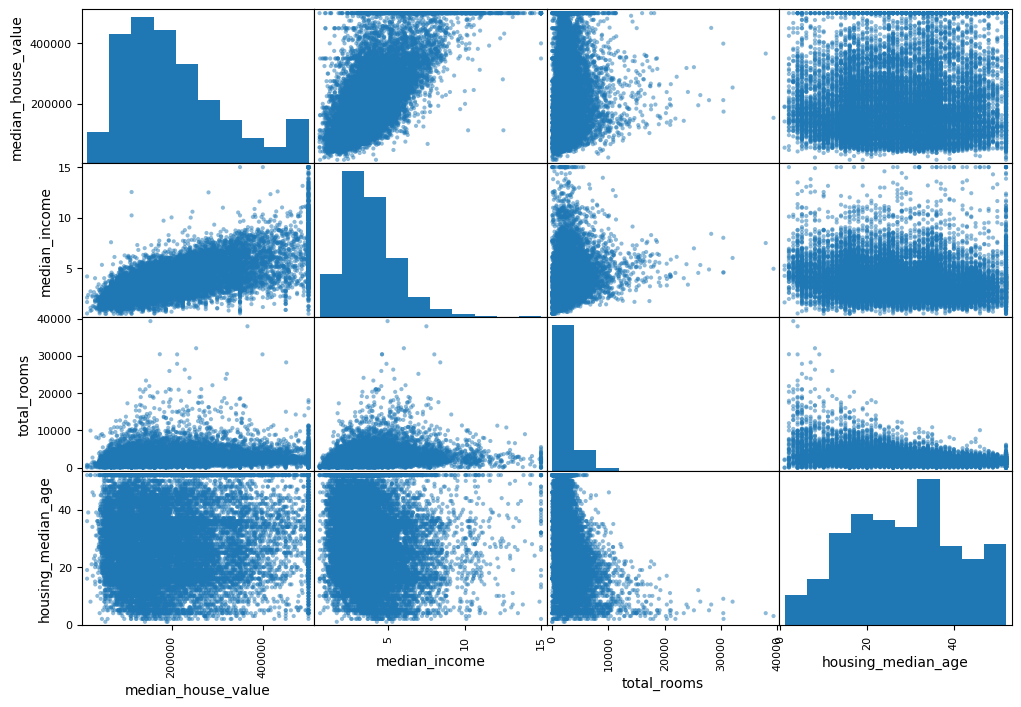

In [29]:
#Using pandas 'scatter matrix' feature these feature correlations can be plotted toward one another

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

Zoom into a promising plot

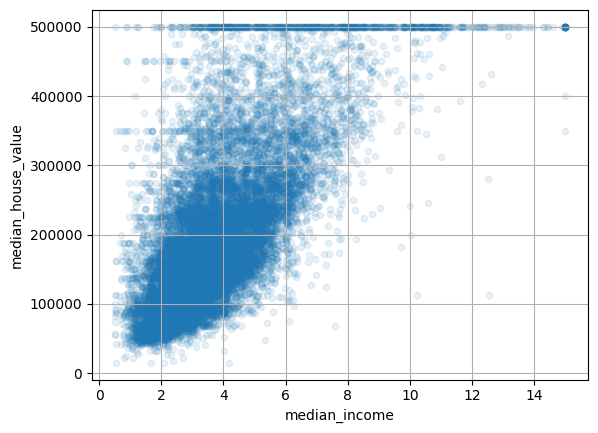

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha =0.1, grid=True)
plt.show()

First thing to notice is there is definitely a strong correlation.  

Second is, there are horizontal lines in the plots, particularly at around $350000 and $450000. We might want to remove these districts otherwise the algorithm might learn to reproduce these quirks.

### Attribute combinations

Creating new attributes by combining two or more existing ones can give you new insights:

In [31]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

In [32]:
# Now we can recheck the correlations again:

corr_matrix = housing.select_dtypes(include=[float, int]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Not too bad, we can see that the newly created "bedrooms_ratio" and "rooms_per_house" have stronger correlations than their 

### **What if you do random operation(s) on a random set(s) of attributes??**

Randomly combining attributes using operations like multiply, divide, or add can be seen as a way to create new features (sometimes called feature construction or feature engineering) that may capture complex relationships and interactions between attributes. However, doing this purely randomly without domain knowledge or guided selection has some pros and cons:

Pros:
* It can potentially discover novel attribute interactions that improve model performance.
* Random combinations can increase feature diversity, which is sometimes beneficial like in ensemble methods.
* In practice, some methods even use random orderings of attributes or random permutations in learning joint distributions, which can still provide good results due to model capacity to learn complex dependencies.

Cons:
* Most random attribute combinations may not be meaningful or predictive and could add noise.
* A large number of random features increases dimensionality, risking overfitting and increased computational cost.
* Without guided feature selection, many random combinations might be redundant or irrelevant, degrading model interpretability and performance.

Generally, feature engineering benefits from some strategic approach — either guided by domain knowledge, statistics, or automated selection methods — rather than purely random combinations. But using random attribute orderings or random feature subsets is a common and effective technique in algorithms like Random Forests, where multiple decision trees each utilize randomly selected features or random splits to improve generalization.

In summary, random attribute combinations as random feature construction can be trialed, often benefiting from subsequent selection or regularization, but purely random operations have a risk of creating mostly irrelevant features. Successful use of randomness in combining attributes often involves ensemble or learning methods that can handle such variation and extract useful signals.

### Prepare the data for Machine Learning Algorithms

In [33]:
# Reverting to a clean data set and also separate the predictors from the labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Cleaning the data

For missing values in the data you have three choices (e.g. total bedrooms attribute has missing values):
* Get rid of the corresponding districts
* Get rid of the whole attribute
* Set the missing values to some value (zero, mean, median, etc.). This is called ***imputation***.

In [34]:
# The code for each option:

# housing.dropna(subset=["total_bedrooms"], inplace=True) # Option 1
# housing.drop("total_bedrooms", axis=1) # Option 2

# Option 3
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [35]:
# Go for option 3 but instead use built-in Scikit-Learn class
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Since the median only works for numerical attributes, exclude text attributes

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num) # Computes the median of each attribute and stores it in 'statistics_' variable
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [36]:
# Now replacing the missing values with the new trained imputer

X = imputer.transform(housing_num)

# Wrap X in a DataFrame and recover the column names and index from housing_num:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


### Fit, Transform and Fit_Transform

fit, transform, and fit_transform in sklearn serve distinct but related roles in data preprocessing:

**fit**: Calculates and stores parameters (such as mean and standard deviation for scalers) from the input data, but does not change the data itself.

**transform**: Applies the learned parameters from a previous fit to actually modify the data (e.g., scale or encode), returning the transformed array.

**fit_transform**: Combines both steps, fitting to the data and then immediately transforming it in one step, typically faster and used mainly with training data.

**Key details**:

Use fit on your training data only, to prevent bias from leaking test data characteristics into your model.

Use transform on your test (or new) data, so it’s processed using parameters learned from the training set, ensuring consistent data transformations without introducing bias.

fit_transform = fit + transform executed together; equivalent to calling .fit(X).transform(X) but a bit more efficient.

| Function        | Purpose           | Use Case      |
|-----------------|-------------------|---------------|
| fit             | Learn parameters  | Training only |
| transform       | Apply parameters  | Train & test  |
| fit_transform   | Fit & transform   | Training only |


### Handling Text and Categorical Attributes

In [37]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(100)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
13797,<1H OCEAN
17771,NEAR OCEAN
13253,NEAR BAY
20352,<1H OCEAN


Most ML algorithms prefer to work with numbers and not Text. So let's convert these categories into numbers:

In [38]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [39]:
# Getting the list of categories to understand what these new values mean:

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

However, there is an issue. The ML algorithms will assume that two nearby values are more similar than two distant values. A solution can be *"one-hot"* encoding. **This basically means to create a binary attribute per category** e.g. "<1H OCEAN" is either 1 or 0 and if it is 1 then the rest of the attributes are set to 0.

In [40]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot # The output, by default, is a SciPy sparse matrix

# Converting it to a NumPy array:
housing_cat_1hot.toarray()

# Get the list of categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
# With Pandas get_dummies() function, it will convert each categorical feature into a one-hot representation

df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [42]:
cat_encoder.transform(df_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

In [43]:
# Accessing the column names:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [44]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [45]:
# This can be used to build a DataFrame around the transformer's output:

df_output = pd.DataFrame(cat_encoder.transform(df_test).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0


### Feature scaling and transformation

One of the most important *transformations* you need to apply to your data is **feature scaling**.  

Two ways: 
* Min-max scaling: Subtract the minimal value and then divide by the difference between min and max. Scikit-Learn provides *Transformer* **MinMaxScalar** for this.
* Standardization: Subtracts the *mean* value, then it divides the result by the **standard deviation**. Standardization is much less affected by outliers! Scikit-Learn provides *Transformer* **StandardScalar** for this.

In [46]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [47]:
from sklearn.preprocessing import StandardScaler

standard_scalar = StandardScaler()
housing_num_standard_scaled = standard_scalar.fit_transform(housing_num)

C:\Users\zanes\AppData\Local\Temp\ipykernel_136152\2515398228.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  housing_num.hist(ax=axes[0], bins=50)
C:\Users\zanes\AppData\Local\Temp\ipykernel_136152\2515398228.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.DataFrame(housing_num_standard_scaled, columns=housing_num.columns).hist(ax=axes[1], bins=50)


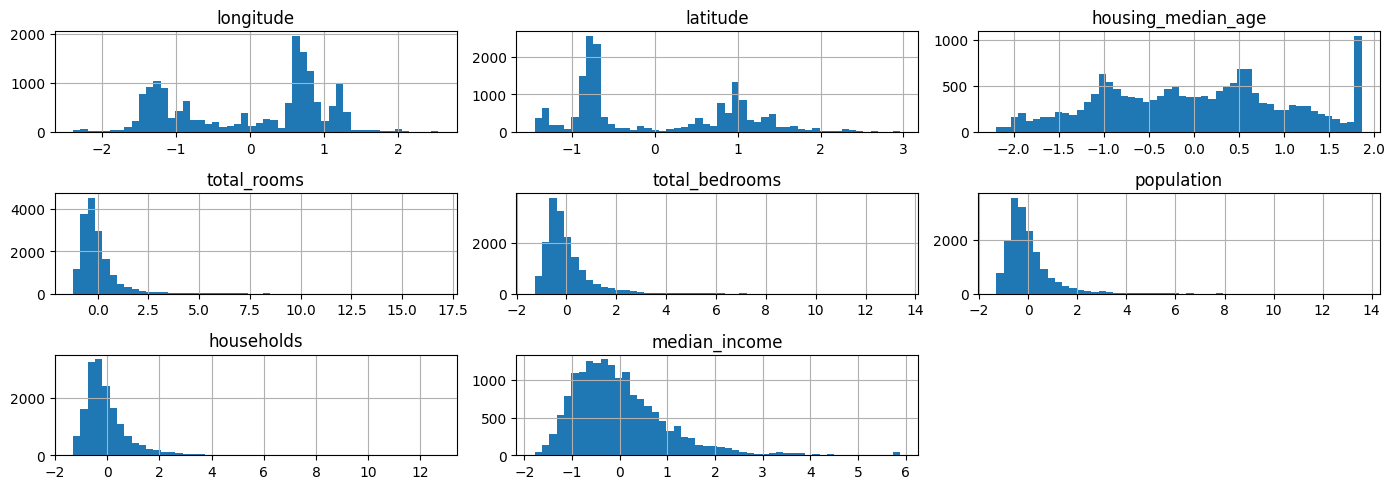

In [48]:
# ...existing code...
import matplotlib.pyplot as plt

# Plot histograms for original and scaled data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

housing_num.hist(ax=axes[0], bins=50)
axes[0].set_title("Original Features")

pd.DataFrame(housing_num_standard_scaled, columns=housing_num.columns).hist(ax=axes[1], bins=50)
axes[1].set_title("Standard Scaled Features")

plt.tight_layout()
plt.show()
# ...existing code...

If a feature has a heavy tail, then it is best to try and *transform* the feature to have a symmetrical distribution.  

Some ways to do this:
* A common way to do this is for **positive features** with a heavy tail to the right, is to replace the feature with its *square root*.
* Also, if the feature has a really long and heavy tail (such as the *power of law distribution*) then replacing the feature with its logarithm may help.
* *Bucketizing* the feature: Chopping the distribution into roughly equally-sized buckets and then replacing each feature value with the index of the bucket it belongs to. e.g this can be used in features like age, test-scores, incomes to make categories like "young-adult" ranging from 18-25 or "high income" ranging from 75000-100000 or "A" for a test score ranging from 80-100.  

For **Multimodal** distributions:
* When a feature has *multimodal distribution* (two or more clear peaks), bucketizing becomes very useful.
* Another way is to add a feature for each of the modes that would represent the similarity between the e.g. *housing median age* and the particular mode.  

**Similarity measure** is typically calculated using the *radial basis function (RBF)*. e.g. the Gaussian RBF similarity between *housing age* $x$ and 35 is given by the following equation:  
$$exp(-\gamma(x-35)^2)$$


 

Where $\gamma$ is the *hyperparameter* that determines how quickly the similarity measure decays as $x$ moves away from 35.

In [49]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35_003 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.03)

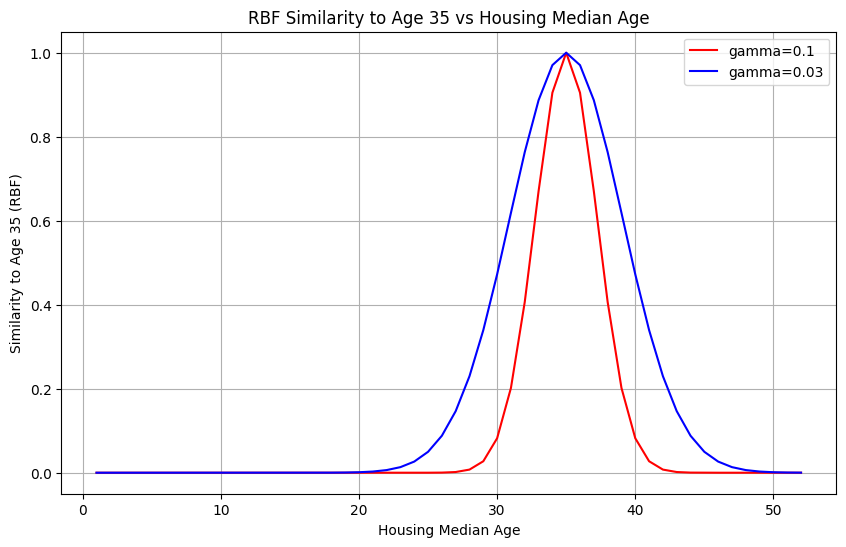

In [50]:
# ...existing code...
import matplotlib.pyplot as plt

sorted_idx = housing["housing_median_age"].argsort()
x = housing["housing_median_age"].iloc[sorted_idx]

plt.figure(figsize=(10, 6))
plt.plot(x, age_simil_35[sorted_idx], "r-", label="gamma=0.1")
plt.plot(x, age_simil_35_003[sorted_idx], "b-", label="gamma=0.03")
plt.xlabel("Housing Median Age")
plt.ylabel("Similarity to Age 35 (RBF)")
plt.title("RBF Similarity to Age 35 vs Housing Median Age")
plt.legend()
plt.grid(True)
plt.show()
# ...existing code...

When you scale the features the target values may also have to be transformed.You may choose to replace the target value with the logarithm of the target value, but then you are no longer predicting th median house value, but the log of the median house value.

One way to overcome this is to use Sci-kit's *inverse transform* method:

In [51]:
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] #pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)

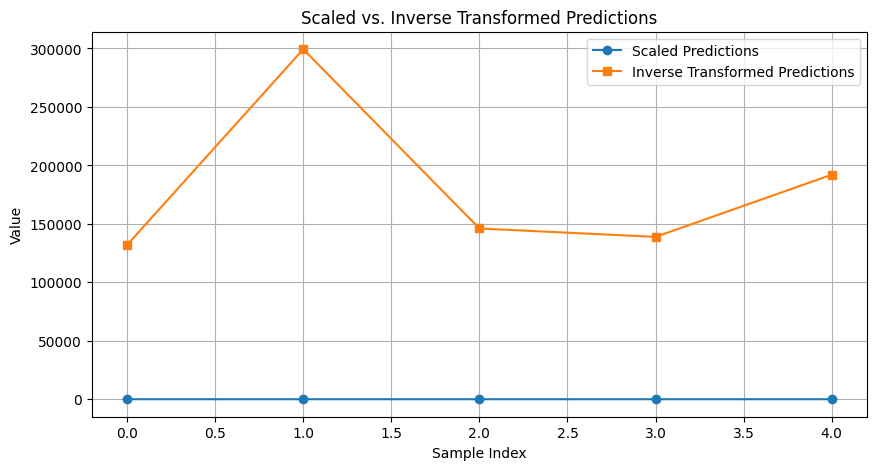

In [52]:
# ...existing code...
import matplotlib.pyplot as plt

# Plot scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(scaled_predictions, "o-", label="Scaled Predictions")
plt.plot(predictions, "s-", label="Inverse Transformed Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Scaled vs. Inverse Transformed Predictions")
plt.legend()
plt.grid(True)
plt.show()
# ...existing code...

In [53]:
# A simpler method:

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

### Creating custom Transformers:

Creating a simple log-transformer and apply to the population feature:

In [54]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

# Making one for the Gaussian RBF:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

The following custom transformer uses **KMeans** clusterer in the *fit()* method to identify the main clusters in the training data and then uses *rbf_kernel()* in the *transform()* method to measure how similar each sample is to each center:

In [55]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self #Always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return[f"Cluster {i}, similarity" for i in range(self.n_clusters)]


### Transformation Pipelines

There are many data transformation steps that need to be executed in the right order. **Fortunately, Scikit-Learn provides a *PipeLine* class to help with such sequences of transformations.**

In [56]:
# Here is a small pipeline that will first impute and then scale the input features:

from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("impute", SimpleImputer(strategy="median")),
                         ("standardize", StandardScaler()),
                         ])

num_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


The *PipeLine* constructor takes a list of name/estimator pairs defining a sequence of steps.  

The estimators must all be *transformers* (i.e must have a *fit_transform()* method), except for the last one, which can be anything: *transformer, predictor* or any type of *estimator*.

In [57]:
# Alternatively you can use the make_pipeline
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [58]:
# Calling the pipelines fit_transform() method and looking at the output:

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

If you want to recover a nice DataFrame (as seen earlier), you can use the pipeline's *get_feature_names_out()* method:

In [59]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

**ColumnTransformer** can help with transforming **all columns** including numerical or categorical attributes:

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown="ignore") #Ignores unknown categories - represents them with zeros
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
]) # Each constructor requires a list triples: Unique name, a transformer, list of names of the columns

Alternatively the following code can be used without listing out any columns or naming any transformers:

In [61]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

**Now we are ready to apply the ColumnTransformer to the housing data**

In [62]:
housing_prepared = preprocessing.fit_transform(housing)

### All-in Pipeline creation:

In short you should create a pipeline that does all of the below (also described in above sections):
1. Imputing or filling in the missing values
2. One-hot encoding - Change categorical features to numerical inputs
3. Feature engineering - Make new features
4. Add similarity clusters or similarity measure - RBF Gaussian
5. Replace features with a long tail - Transforming or bucketizing
6. Standardize all numerical features to have roughly the same scale - Scaling 

In [63]:
def column_ratio(X): # Combines features and computes the input ratio between input features 0 and 1
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, features_names_in):
    return ["ratio"] #Features names in

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
# To be continued...
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log,feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0,random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(),["total_bedrooms","total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population","households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households",
                             "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [64]:
housing_prepared = preprocessing.fit_transform(housing)
# housing_prepared.shape
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0, similarity',
       'geo__Cluster 1, similarity', 'geo__Cluster 2, similarity',
       'geo__Cluster 3, similarity', 'geo__Cluster 4, similarity',
       'geo__Cluster 5, similarity', 'geo__Cluster 6, similarity',
       'geo__Cluster 7, similarity', 'geo__Cluster 8, similarity',
       'geo__Cluster 9, similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and Train a Model

In [65]:
# Basic Linear regression model to get started:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [69]:
# Now that there is a working linear regression model, try it out on the training set:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) #Round to the nearest hundred


array([246000., 372700., 135700.,  91400., 330900.])

In [68]:
housing_labels.iloc[:5].values #Check the actual prices

array([458300., 483800., 101700.,  96100., 361800.])

In [75]:
#Use the RMSE to measure the performance on the whole training set:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_rmse)
lin_rmse

np.float64(68972.88910758478)

The Median housing values range from $120 000 to $265 000 and has a prediction error of around $68 972, clearly not great and an example of **underfitting**

Some main ways to solve this:
* Select a more powerful model
* Feed the training algorithm better features
* Reduce the constraints of the model  

We'll now try the *DecisionTreeRegressor*

In [76]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [77]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_rmse)
tree_rmse

np.float64(0.0)

0 Error! Most likely this model is badly overfitting! You need to use part of the training set for training and part for validation!

### Better Evaluation using Cross-validation

In [80]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10) 
#Makes a random training split of 10 non-overlapping subsets called 'folds'
#It then trains and evaluates the decision tree 10 times, the result is an array containing 10 evaluation scores

pd.Series(tree_rmses).describe()

count       10.000000
mean     66573.734600
std       1103.402323
min      64607.896046
25%      66204.731788
50%      66388.272499
75%      66826.257468
max      68532.210664
dtype: float64

This method not only shows you an estimate of the performance but also estimates how precise the estimate is with std_dev.  

Now we know with surety this model is overfitting since the training error was extremely low and the cross-validation error very high!  

Now try a *RandomForestRegressor*. **This model works by training many decision trees on random subsets of the features and then averaging out their predictions.** Such a model that is composed of many models are called *Ensembles*.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                    scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47038.092799
std       1021.491757
min      45495.976649
25%      46510.418013
50%      47118.719249
75%      47480.519175
max      49140.832210
dtype: float64

In [83]:
#Do the normal training validation
forest_reg_tv = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg_tv.fit(housing,housing_labels)
housing_predictions = forest_reg_tv.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

np.float64(17551.212250087698)

Cross validation shows ~$47 000 error while training validation shows ~$17500. This shows that there is still quite some overfitting taking place!

### Fine-Tuning your Model

**Grid Search** is a great way of *hyper-parameter tuning*. You can do this by using Sklearn built in functions. You can tell it which parameters to tune and the values, and it will find the best combination.

In [93]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([("preprocessing", preprocessing),
                          ("random_forest", RandomForestRegressor(random_state=42)),
                          ])
param_grid = [
    # {'preprocessing__geo__n_clusters': [5, 8, 10],
    #  'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [25, 30, 35, 40], #Re-evaluate since the best_params were 15 which was the max
     'random_forest__max_features': [4, 6, 8]}, #Re-evaluate since the best_params were 6 which was the minimum
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [25, 30, ...], 'random_forest__max_features': [4, 6, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [94]:
#Checking the best params:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 40, 'random_forest__max_features': 8}

In [95]:
#Checking the new test scores
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,5.673815,0.037265,0.124660,0.025607,40,8,"{'preprocessing__geo__n_clusters': 40, 'random...",-41413.510970,-42463.977919,-42954.007617,-42277.165502,642.628270,1
10,4.368400,0.023148,0.106936,0.001868,40,6,"{'preprocessing__geo__n_clusters': 40, 'random...",-41271.207651,-42636.766689,-42936.440452,-42281.471597,724.764799,2
7,4.333933,0.011024,0.105762,0.001301,35,6,"{'preprocessing__geo__n_clusters': 35, 'random...",-41545.233825,-42423.892456,-43107.165814,-42358.764032,639.316911,3
8,5.575711,0.012769,0.105979,0.001335,35,8,"{'preprocessing__geo__n_clusters': 35, 'random...",-41691.257882,-42619.589521,-43091.468466,-42467.438623,581.669919,4
4,4.296663,0.053192,0.112906,0.009039,30,6,"{'preprocessing__geo__n_clusters': 30, 'random...",-41710.075058,-42429.044251,-43351.989634,-42497.036314,672.030783,5


**RandomizedSearch** is often more preferred, especially if the hyperparameter space is large.

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                                scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....001E2A0254EC0>, 'random_forest__max_features': <scipy.stats....001E2A02DC050>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### Analyzing the best models and their Errors

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [98]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.02, 0.01, 0.02, 0.01, 0.  , 0.01, 0.02,
       0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.03, 0.01, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.02, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [99]:
#Sort them in descending order and display next to their attribute:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.18599734460509473), 'log__median_income'),
 (np.float64(0.07338850855844488), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06556941990883974), 'bedrooms__ratio'),
 (np.float64(0.05364871007672531), 'rooms_per_house__ratio'),
 (np.float64(0.04598870861894748), 'people_per_house__ratio'),
 (np.float64(0.04175269214442518), 'geo__Cluster 30, similarity'),
 (np.float64(0.025976797232869678), 'geo__Cluster 25, similarity'),
 (np.float64(0.023595895886342252), 'geo__Cluster 36, similarity'),
 (np.float64(0.02021056221732893), 'geo__Cluster 9, similarity'),
 (np.float64(0.018606917076661445), 'geo__Cluster 34, similarity'),
 (np.float64(0.01813798837462886), 'geo__Cluster 37, similarity'),
 (np.float64(0.017404353166326745), 'geo__Cluster 18, similarity'),
 (np.float64(0.01677838614384489), 'geo__Cluster 1, similarity'),
 (np.float64(0.015459009666188978), 'geo__Cluster 7, similarity'),
 (np.float64(0.015325731028175922), 'geo__Cluster 32, similarity'),
 (np.float64(0.0150737

### Evaluating your system on the *Test set*

Get the predictors and labels from the test set and run your final_model to transform the data and make predictions, then evaluate these predictions:

In [101]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_rmse)
print(final_rmse)

41445.533268606625


In [102]:
#Getting an idea of the confidence level of the generalization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39293.55594722, 43491.1590655 ])

### Launch, Monitor and Maintain!

1. Save the model you trained,
2. transfer the file to your production environment,
3. load it!

In [103]:
#Saving the model:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

**Remember to import any custom classes and functions the model relies on before loading the model!**